# Data Science Pipeline Tutorial
### By Justin DeVito

In [1]:
import pandas as pd
import requests as req
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

## Getting Data

This notebook will walk through the process of using Python for identifying/scraping data, performing exploratory data analysis, and gaining insight from the data. 

Data can be found anywhere online. If you're lucky there's an API that makes it easy to request data from a database, but sometimes it'll take a bit more elbow grease. If data is shown on a website you could read the HTML into Python, and parse through it to find the relevant data you want (libraries such as "Beautiful Soup" would help with this). The data you find does not initially need to be perfectly formatted for you to be able to perform data analysis on it.

In this notebook I am going to look at how greenhouse gas emissions have changed over time from 1990-2014, and global temperatures over that same span. I initially found greenhouse gas data for UN member nations (couldn't find a database with global emissions) on the United Nations' website, but each variable (carbon dioxide, methane, etc) was stored in a different dataset. I was able to find the same data on Kaggle, a website where you can find many datasets and other data science resources, which allowed me to download everyting I wanted directly as a CSV file.

UN website link:
http://data.un.org/Explorer.aspx

Kaggle link:
https://www.kaggle.com/unitednations/international-greenhouse-gas-emissions

With that CSV file I can easily read it into Python using a library called Pandas, which helpes with storing the data and memory as a "dataframe" and provides many functions that help with manipulating the data.

In [2]:
# imports the csv into a pandas dataframe object
ghg_data = pd.read_csv("greenhouse_gas_inventory_data.csv")

# shows the first 5 rows
ghg_data.head()

,country_or_area,year,value,category
0,Australia,2014,393126.946994,carbon_dioxide_co2_emissions_without_land_use_...
1,Australia,2013,396913.936530,carbon_dioxide_co2_emissions_without_land_use_...
2,Australia,2012,406462.847704,carbon_dioxide_co2_emissions_without_land_use_...
3,Australia,2011,403705.528314,carbon_dioxide_co2_emissions_without_land_use_...
4,Australia,2010,406200.993184,carbon_dioxide_co2_emissions_without_land_use_...


I found the global temperature data on NASA's website as a .txt file; it has the recorded "temperature anomaly" for each year from 1880 to 2020, where "temperature anomaly" is the temperature in Celsius *relative* to the average temperature from 1951-1980. It contains the exact values as well as "smoothed" values, but I will only deal with the exact data here. To import this data I'll use the requests library to get the data as a string, and then manipulate it using Python until I can put it into a dataframe.

Link to data:
https://data.giss.nasa.gov/gistemp/graphs/graph_data/Global_Mean_Estimates_based_on_Land_and_Ocean_Data/graph.txt

Description of data:
https://climate.nasa.gov/vital-signs/global-temperature/

In [3]:
# gets the text file from nasa.gov
web = req.get("https://data.giss.nasa.gov/gistemp/graphs/graph_data/Global_Mean_Estimates_based_on_Land_and_Ocean_Data/graph.txt")

# first 500 characters
web.text[:500]

# this is going to need a bit of cleaning up...

'Land-Ocean Temperature Index (C)\n--------------------------------\n\nYear No_Smoothing  Lowess(5)\n----------------------------\n1880     -0.16     -0.08\n1881     -0.08     -0.12\n1882     -0.10     -0.16\n1883     -0.16     -0.20\n1884     -0.28     -0.23\n1885     -0.33     -0.26\n1886     -0.31     -0.27\n1887     -0.36     -0.27\n1888     -0.17     -0.26\n1889     -0.10     -0.25\n1890     -0.35     -0.25\n1891     -0.22     -0.25\n1892     -0.27     -0.26\n1893     -0.31     -0.26\n1894     -0.30     -0.24\n'

In [4]:
# makes an array of each line as a string, and removes junk from the beginning and end
arr = web.text.split("\n")[5:-1]

arr[:5]

['1880     -0.16     -0.08',
 '1881     -0.08     -0.12',
 '1882     -0.10     -0.16',
 '1883     -0.16     -0.20',
 '1884     -0.28     -0.23']

In [5]:
# makes a dataframe from a 2d matrix of the year and temp columns
temp_data = pd.DataFrame(list(map(lambda s: s.split("     ")[:2], arr)))
temp_data.columns = ["year", "temp"]
temp_data.year = temp_data.year.transform(lambda y: int(y)) # makes consistent with ghg data
temp_data.temp = temp_data.temp.transform(lambda y: float(y))

temp_data.head()

,year,temp
0,1880,-0.16
1,1881,-0.08
2,1882,-0.10
3,1883,-0.16
4,1884,-0.28


## Exploring the Data

Now that the data is scraped and loaded into memory, we can beginning exploring the data to get a better understanding of what we're working with. To do this, I'll first organize the dataframes, and then make some preliminary plots to see how the data changes with time.

In [6]:
# prints all categories in ghg_data, will rename to make dataframe easier to read
for s in ghg_data.category.drop_duplicates().values:
    print(s + "\n")

carbon_dioxide_co2_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent

greenhouse_gas_ghgs_emissions_including_indirect_co2_without_lulucf_in_kilotonne_co2_equivalent

greenhouse_gas_ghgs_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent

hydrofluorocarbons_hfcs_emissions_in_kilotonne_co2_equivalent

methane_ch4_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent

nitrogen_trifluoride_nf3_emissions_in_kilotonne_co2_equivalent

nitrous_oxide_n2o_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent

perfluorocarbons_pfcs_emissions_in_kilotonne_co2_equivalent

sulphur_hexafluoride_sf6_emissions_in_kilotonne_co2_equivalent

unspecified_mix_of_hydrofluorocarbons_hfcs_and_perfluorocarbons_pfcs_emissions_in_kilotonne_co2_equivalent



In [7]:
# pivots table to give each category a column, takes mean temp across all countries/areas
df = ghg_data.pivot_table(index="year", columns=["category"], aggfunc="mean")
df.columns = df.columns.droplevel()
df.columns = ["CO2", "GHGs", "GHGs_2", "HFCs", "CH4", "NF3", "N2O", "PFCs", "SF6", "HFCs_PFCs_mix"]

# GHGs_2 does not have indirect co2, so let's just drop in
df = df.drop("GHGs_2", axis=1)

# some data has HFCs and PFCs combined, so let's just combine them for the whole dataset
df["HFCs_PFCs_mix"] = df["HFCs_PFCs_mix"] + df["HFCs"] + df["PFCs"]
df = df.drop(["HFCs", "PFCs"], axis=1)

# adds a column for temp data
df = df.join(temp_data.set_index("year"), how="inner")

df.head()

,CO2,GHGs,CH4,NF3,N2O,SF6,HFCs_PFCs_mix,temp
year,,,,,,,,
1990,455379.936166,633243.305620,87094.095299,18.383797,36194.407289,2074.533801,14357.312190,0.45
1991,446193.986253,618145.225307,84511.860775,18.871227,34748.195912,2055.211806,13363.035486,0.41
1992,431901.700232,597397.641955,81528.146297,19.408413,33609.735740,2059.102498,12162.126651,0.22
1993,426304.676894,588482.640738,79167.104710,23.278081,32976.558788,2075.474610,11839.852256,0.23
1994,421997.498173,580717.203385,77076.932886,25.988809,32253.689517,2029.666582,11960.795374,0.32


To get a dataframe I could easily use to make plots, I first pivoted the greenhouse gas data so each category has its own column, and summed across all countries for each year; I also got rid of data for total greenhouse gas emissions without indirect CO2, I will only use the full total for my analysis in this tutorial. I also noticed some countries logged emissions for HFCs and PFCs seperately, but others didn't. To simplify analysis I just combined all of those emissions into one column called `HFCs_PFCs_mix`. Lastly, I added a column with the temperature data.

The column names represent the categories as follows:
 - `GHGs`: total greenhouse gas emissions
 - `CO2`: carbon dioxide
 - `CH4`: methane
 - `NF3`: nitrogen trifluoride
 - `N2O`: nitrous oxide
 - `SF6`: sulfur hexafluoride
 - `HFCs_PFCs_mix`: hydrofluorocarbons and perfluorocarbons (perfluorocarbons can also be simply called "fluorocarbons")
 - `temp`: NASA temperature data

Now, with the dataframe organized, we can make some preliminary plots.

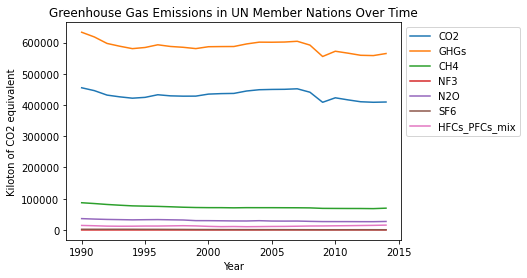

In [8]:
df.drop(["temp"], axis=1).plot()
plt.xlabel("Year")
plt.ylabel("Kiloton of CO2 equivalent")
plt.title("Greenhouse Gas Emissions in UN Member Nations Over Time")
plt.legend(bbox_to_anchor=(1,1), loc="upper left");

The plot above has a line for each column in the dataframe (except temp, it has different units). This plot shows that the total greenhouse gas emissions (GHGs) are really dominated by carbon dioxide (CO2); it has by far the highest emissions by mass out of all the greenhouse gasses shown here. It's hard to see if there is a trend in the other greenhouse gas emissions with time because the y-axis here is only really suited for the scale of CO2 emissions. To fix this, I'll make a seperate plot for each of the greenhouse gasses. 

I predict that when I make those plots, the total greenhouse gas plot and CO2 plot will look very similar, like they do here, because most of the total greenhouse gas emissions are CO2 emissions.

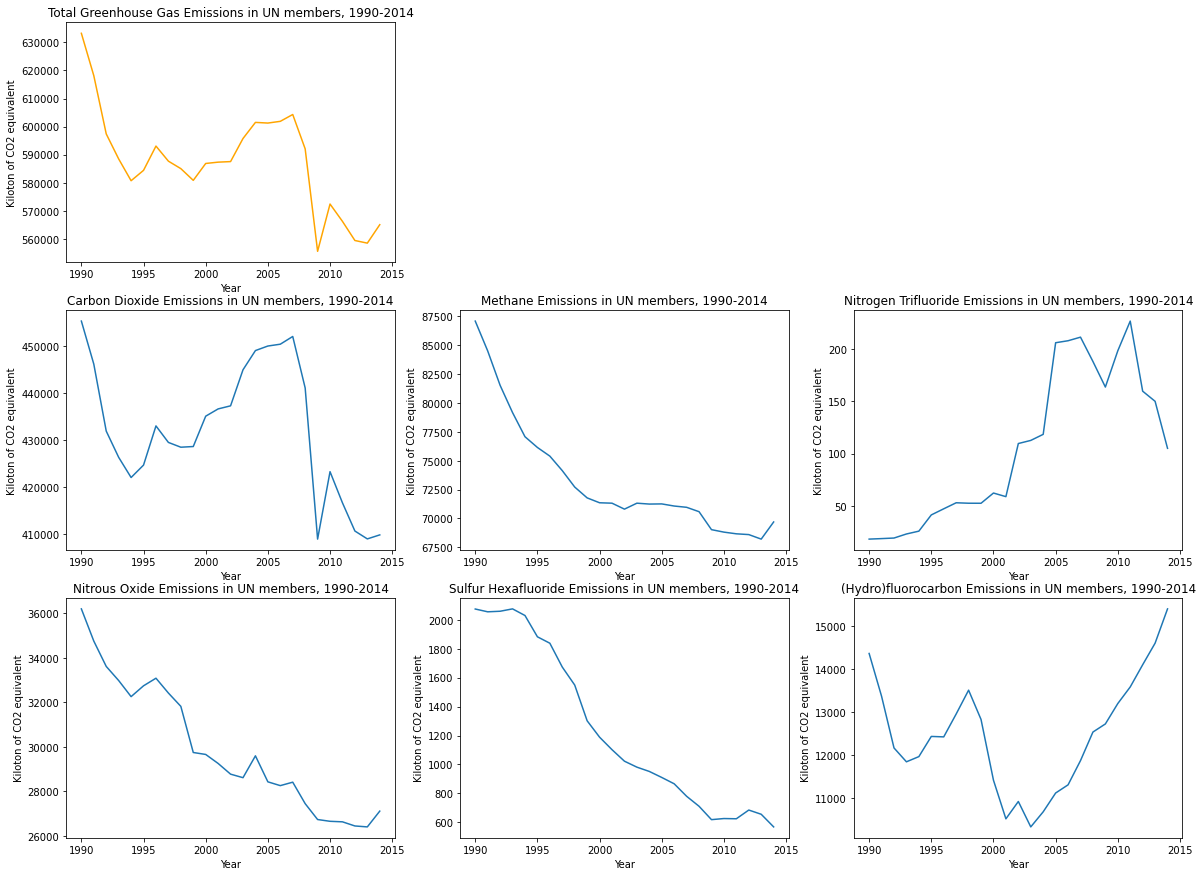

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
fig.delaxes(ax[0][1])
fig.delaxes(ax[0][2])
df["GHGs"].plot(ax=ax[0][0], title="Total Greenhouse Gas Emissions in UN members, 1990-2014", color="orange")
df["CO2"].plot(ax=ax[1][0], title="Carbon Dioxide Emissions in UN members, 1990-2014")
df["CH4"].plot(ax=ax[1][1], title="Methane Emissions in UN members, 1990-2014")
df["NF3"].plot(ax=ax[1][2], title="Nitrogen Trifluoride Emissions in UN members, 1990-2014")
df["N2O"].plot(ax=ax[2][0], title="Nitrous Oxide Emissions in UN members, 1990-2014")
df["SF6"].plot(ax=ax[2][1], title="Sulfur Hexafluoride Emissions in UN members, 1990-2014")
df["HFCs_PFCs_mix"].plot(ax=ax[2][2], title="(Hydro)fluorocarbon Emissions in UN members, 1990-2014")

plt.setp(ax, xlabel="Year")
plt.setp(ax, ylabel="Kiloton of CO2 equivalent");

I created 6 plots for each of the greenhouse gas categories plus one for the total greenhouse gas emissions. By looking at the y-axis we can see on what scales each of these types of emissions are. The largest, as I noted earlier, is carbon dioxide (CO2)—followed by methane (CH4), nitrous oxide (N2O), hydrofluorocarbons and (per)fluorocarbons (HFCs/PFCs), sulfur hexafluoride (SF6), and finally, nitrogen trifluoride (NF3).

We can also see from the plots a general trend in most of the categories. For example methane, nitrous oxide, and sulfur hexafluoride all appear to have clear downward trends with time, although I can't tell if the relationships are linear or not. My prediction of the greenhouse gas and carbon dioxide plots looking similar holds mostly true, although the right-hand side appears to be a little lower in the GHGs plot than the CO2 one. This, I believe, is due to the fact that many of the greenhouse gasses other than CO2 have downward trends with time, including the second largest contributer: methane.

Now I'll plot the temperature data to get see if there are any obvious trends there. My prediction here is that the temperature will be shown increasing with time, based on what I've heard about global warming.

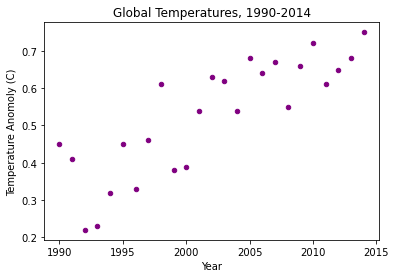

In [10]:
df.reset_index().plot(x="year", y="temp", kind="scatter", title="Global Temperatures, 1990-2014", color="purple")
plt.xlabel("Year")
plt.ylabel("Temperature Anomoly (C)");

This scatter plot has a point for each year from 1990-2014 representing the global temperature in that year. It looks to have a linear trend upwards with time—enough so that I will say we can reject the null hypothesis of no correlation between temperature and year. To make this trend even clearer, I'll add a linear regression line to the plot.

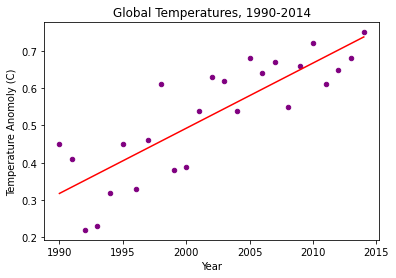

In [11]:
df.reset_index().plot(x="year", y="temp", kind="scatter", title="Global Temperatures, 1990-2014", color="purple")
plt.xlabel("Year")
plt.ylabel("Temperature Anomoly (C)")

X = df.index.values.reshape(-1, 1)
y = df.temp
reg = LinearRegression().fit(X, y)
reg_df = pd.DataFrame(reg.predict(df.index.values.reshape(-1, 1))).set_index(df.index.values)
plt.plot(reg_df, color="red");

In my opinion, this linear regression matches the data pretty well. It was made using a library called "scikit-learn" which here uses least squares to create a model from the x and y data.

## Hypothesis Testing & Machine Learning